In [1]:
# Handling
import pandas as pd
import requests 
import heapq
import warnings
import time
import dill as pickle
import sys

# Math
from math import radians, cos, sin, asin, sqrt

# Visualize
import matplotlib.pyplot as plt

# Warings
warnings.filterwarnings('ignore')

# Moduel
from selectDatasetFluid import *
from calculateRiskIndex import *
from loadDatabase import *

<span style='background-color:rgba(0,0,255,0.3); color:white; padding: 5px; border-radius:5px;'> 알고리즘 프로세스 </span>

* 주소 → 위도, 경도 반환 알고리즘 
* 노드 클래스 생성
* 격자 이웃 거리 산출 알고리즘 
* 노드 생성 알고리즘
* 휴리스틱 산출 함수 
* 경로 찾기 알고리즘 

<span style='border:0.5px solid black; padding:5px; border-radius:5px;'> 노드 클래스 저장 및 로드  </span>

In [2]:
def save_nodes(file_name,nodes):
    # 사용 x
    #sys.setrecursionlimit(5000)  # 예를 들어 기본 재귀 한계를 10000으로 늘림 
    
    with open(f'{file_name}.pickle', 'wb') as f:
        pickle.dump(nodes, f)

In [3]:
def load_nodes(file_name):
    with open(f'{file_name}.pickle', 'rb') as f:
        loaded_obj  = pickle.load(f)
        return loaded_obj

<span style='border:0.5px solid black; padding:5px; border-radius:5px;'> 주소 → 위도, 경도 반환 알고리즘  </span>

In [4]:
def get_latitude_longitude(address):
    """
    주어진 주소 또는 지명에 대한 위도와 경도를 반환하는 함수.
    
    :param address: 조회할 주소 또는 지명의 문자열
    :return: (위도, 경도)의 튜플. 조회에 실패한 경우 (None, None) 반환
    """
    # Nominatim API의 Geocoding URL
    url = 'https://nominatim.openstreetmap.org/search'
    params = {
        'q': address,
        'format': 'json',
        'limit': 1  # 최상위 결과 하나만 반환
    }
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()  # 오류 응답을 예외로 처리
        results = response.json()
        
        if results:
            # 첫 번째 결과에서 위도와 경도 추출
            latitude = results[0]['lat'] 
            longitude = results[0]['lon']
            #print(longitude, latitude)
            return (float(longitude), float(latitude))
        else:
            return (None, None)
    except requests.RequestException as e:
        print(f"Error during requests to {url}: {e}")
        return (None, None)

In [5]:
def look_for_nearby_location(target_lon,target_lat):
    
    # 1. 격자 데이터 로드
    data = get_dataframe_from_database_fluid('an_grid_point')

    # 2. 각 지점까지의 거리를 계산하고 가장 가까운 지점을 찾다
    closest_point = None
    min_distance = float('inf')
    
    for lon,lat,grid_id,district in data[['LON','LAT','ID','DISTRICT']].values:
        #print(type(lon),type(lat),type(target_lon), type(target_lat))
        distance = haversine(target_lon, target_lat, lon, lat)
        if distance < min_distance:
            min_distance = distance
            closest_lon = lon
            closest_lat = lat
            closest_grid = grid_id
            closest_district = district
    
    # 3. 만약 거리가 500m 이상이면 예외처리
    if min_distance >= 0.5:
       # 사용자 정의 오류 메시지와 함께 ValueError 발생
        raise ValueError("위치를 찾을 수 없습니다.")
    else:
        pass
    
    return closest_lon, closest_lat, closest_grid, closest_district

In [6]:
def find_objective_grid(address):
    
    # 검색어를 통한 위도, 경도 추출
    target_lon,target_lat = get_latitude_longitude(address)
    
    # 그리드에서 가장 가까운 위도,경도 추출
    closest_lon, closest_lat, closest_grid, closest_district = look_for_nearby_location(target_lon,target_lat)
    
    return closest_lon, closest_lat, closest_grid, closest_district

<span style='border:0.5px solid black; padding:5px; border-radius:5px;'> 노드 클래스 생성 </span>

In [7]:
class Node:
    def __init__(self, id, lat, lon, rank):
        self.id = id  # 노드의 고유 식별자
        self.lat = lat  # 노드의 위도
        self.lon = lon  # 노드의 경도
        self.rank = rank  # 노드의 순위 또는 비용
        self.neighbors = []  # 이 노드의 이웃 노드들
        self.parent = None  # A* 알고리즘에서 경로를 추적하기 위한 부모 노드
        self.g = float('inf')  # 시작 노드로부터의 비용
        self.f = float('inf')  # g + h (휴리스틱 포함 총 비용)
    
    def add_neighbor(self, neighbor):
        # 이웃 노드를 추가하는 메소드
        self.neighbors.append(neighbor)

<span style='border:0.5px solid black; padding:5px; border-radius:5px;'> 격자 이웃 거리 산출 알고리즘  </span>

In [8]:
# 격자의 이웃을 결정하기 위한 함수를 정의합니다.
def haversine(lon1, lat1, lon2, lat2):
    """
    두 좌표(위도, 경도) 사이의 거리를 킬로미터로 반환합니다.
    """
    # 위도와 경도를 라디안으로 변환
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine 공식
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # 지구 반경(km)
    return c * r

<span style='border:0.5px solid black; padding:5px; border-radius:5px;'> 휴리스틱 산출 함수 </span>

In [9]:
# 휴리스틱 함수를 정의합니다.
def heuristic(node, goal):
    return haversine(node.lon, node.lat, goal.lon, goal.lat)


# A* 알고리즘의 초기화 및 실행을 위한 함수를 추가로 정의합니다.
def initialize_a_star(start_node,goal_node):
    """A* 탐색을 위한 초기화 함수"""
    start_node.g = 0  # 시작 노드의 g 값을 0으로 설정
    start_node.f = start_node.g + heuristic(start_node, goal_node)  # 시작 노드의 f 값 계산

<span style='border:0.5px solid black; padding:5px; border-radius:5px;'> 노드 생성 알고리즘  </span>

In [10]:
# 각 격자를 노드로 변환하고 이웃을 할당하는 함수를 정의합니다.
def create_grapha(df, radius=0.45):
    """
    데이터프레임으로부터 그래프를 생성합니다. radius는 이웃을 결정하기 위한 반경(km)입니다.
    """
    nodes = {}
    for index, row in df.iterrows():
        node = Node(row['ID'], row['LAT'], row['LON'], row['RANK'])
        nodes[node.id] = node

    # 각 노드에 대해 이웃을 결정합니다.
    for node in nodes.values():
        for potential_neighbor in nodes.values():
            if node != potential_neighbor:
                distance = haversine(node.lon, node.lat, potential_neighbor.lon, potential_neighbor.lat)
                if distance < radius:  # 이웃으로 정의할 반경 내에 있으면 이웃으로 추가
                    node.add_neighbor(potential_neighbor)

    return nodes

In [11]:
# 각 격자의 Nodes를 반환함
def classify_nodes():
    
    # 데이터 로드
    nodes= get_dataframe_from_database_fluid('nodes')
    neighbors= get_dataframe_from_database_fluid('neighbors')
    
    
    nodes_dict={}
    neighbor_dict = {}
    
    for index, row in neighbors.iterrows():
        if row['ID'] not in neighbor_dict:
            neighbor_dict[row['ID']] = []
        neighbor_dict[row['ID']].append(row['NEIGHBOR_ID'])


    for index, row in nodes.iterrows():
        node = Node(row['ID'], row['LAT'], row['LON'], row['RANK'])
        nodes_dict[node.id] = node

    # 이웃 설정
    for node_id, neighbors_ids in neighbor_dict.items():
        node = nodes_dict[node_id]
        for neighbor_id in neighbors_ids:
            neighbor_node = nodes_dict[neighbor_id]  # 이웃 ID를 사용하여 노드 객체를 찾음
            node.add_neighbor(neighbor_node)  # 노드 객체를 이웃으로 추가
                
    return nodes_dict

<span style='border:0.5px solid black; padding:5px; border-radius:5px;'> 경로 찾기 알고리즘  </span>

In [12]:
def calculate_by_proportion(tentative_g_score,heuristic):
    """ 격자 점수와 격자와 목적지의 거리를 비율로 산출 
    """
    # 1. 격자 점수 비율 변환
    tentative_g_score_ratio = np.round((tentative_g_score/10921)*100,2)
    
    # 2. 격자와 목적이의 거기 비율 변환
    heuristic_ratio = np.round((heuristic/20)*100,2)
    
    return tentative_g_score_ratio,heuristic_ratio

In [13]:
# Given the previously defined Node class, create_graph, and heuristic function,
# let's attempt to define the A* search algorithm once more, which will output
# only the latitude and longitude for the optimal path.

def a_star_search(start, goal):
    
    # 비용함수 추적 리스트
    neighbor_f_bowl = []
    
    print('시작')
    initialize_a_star(start,goal)  # 시작 노드의 g 값을 0으로 초기화
    
    # The open set contains nodes to be evaluated, start with the start node
    open_set = [(start.f, start)]
    heapq.heapify(open_set)  # Transform list into a heap
    
    while open_set:
        # Pop the node with the lowest f score
        current_f, current = heapq.heappop(open_set)
        
        # If the goal has been reached, reconstruct and return the path
        if current == goal:
            print("목적지 도착")
            path = []
            while current:
                path.append((current.lat, current.lon, current.id))
                current = current.parent
            return path[::-1]  # Return reversed path

        # Go through all the neighboring nodes
        for neighbor in current.neighbors:
            #print(f"{current.id} 번의 {neighbor.id}번 이웃 노드")
            # The distance from start to a neighbor
            # tentative_g_score = current.g + neighbor.rank / 총 이동비용 
            tentative_g_score = neighbor.rank #현재 격자 이동비용
            
        
            # If this path to neighbor is better than any previous one, record it
            if tentative_g_score < neighbor.g:
                neighbor.parent = current
                neighbor.g = tentative_g_score
                tentative_g_score_ratio,heuristic_ratio = calculate_by_proportion(tentative_g_score,heuristic(neighbor, goal))
                neighbor.f = (tentative_g_score_ratio*0.25) + (heuristic_ratio*0.75)
                #neighbor.f = tentative_g_score + heuristic(neighbor, goal)
                print(f'이웃 노드의 비용 함수(f):{neighbor.f}')
                
                if neighbor.f not in neighbor_f_bowl:
                    heapq.heappush(open_set, (neighbor.f, neighbor))
                    # 비용함수 추가
                    neighbor_f_bowl.append(neighbor.f)

    # 만약 우리가 여기 있다면 목표를 달성하기 위한 길은 없다
    return []

<span style='border:0.5px solid black; padding:5px; border-radius:5px;'> 경로 찾기 알고리즘 적용 </span>

In [14]:
def find_best_route(start_address,arrival_address):
    
    # 1.격자 순위 데이터 로드
    nodes = classify_nodes()
    
    # 2.가장 가까운 그리도 번호 추출
    start_lon, start_lat, start_grid, start_district = find_objective_grid(start_address) # 시작 지점
    arrival_lon, arrival_lat, arrival_grid, arrival_district = find_objective_grid(arrival_address) # 도착 지점
    
    # 3.최적경로 설정
    optimal_path = a_star_search(nodes[start_grid],nodes[arrival_grid])
    
    # 4.위험지표 산출
    high_ranking_data = calculate_risk_scores(optimal_path)
    
    # 5.위험지표 튜플 반환
    high_ranking_risk_index = throw_tuple_price(high_ranking_data)
    
    # 6.위험지표 제이슨 반환
    throw_jason = convert_jason(high_ranking_risk_index)
    
    # 7. 평균지표 제이슨 반환
    mean_jason = calculate_group_mean(high_ranking_data)
    
    # 8. 제이슨 추가 반환
    jason = combine_dictionaries(throw_jason,mean_jason)
    
    return optimal_path,jason

In [19]:
# 함수 실행 시간 측정 시작
start_time = time.time()

#optimal_path,jason = find_best_route('구로디지털단지','인헌중학교') # 경로 잘 찾음
#optimal_path,throw_jason= find_best_route('성수역','중곡역') 
optimal_path,throw_jason = find_best_route('수서역','서울역')  

# 함수 실행 시간 측정 종료
end_time = time.time()

# 실행 시간 계산 (초 단위)
elapsed_time_seconds = end_time - start_time

# 초를 분으로 변환
elapsed_time_minutes = elapsed_time_seconds / 60

print(f"함수 실행 시간: {elapsed_time_minutes:.2f}분")

시작
이웃 노드의 비용 함수(f):65.265
이웃 노드의 비용 함수(f):62.9825
이웃 노드의 비용 함수(f):59.57
이웃 노드의 비용 함수(f):63.10999999999999
이웃 노드의 비용 함수(f):59.665
이웃 노드의 비용 함수(f):60.475
이웃 노드의 비용 함수(f):62.97
이웃 노드의 비용 함수(f):63.29750000000001
이웃 노드의 비용 함수(f):59.2075
이웃 노드의 비용 함수(f):64.91000000000001
이웃 노드의 비용 함수(f):55.872499999999995
이웃 노드의 비용 함수(f):65.4625
이웃 노드의 비용 함수(f):58.63999999999999
이웃 노드의 비용 함수(f):59.6975
이웃 노드의 비용 함수(f):55.7425
이웃 노드의 비용 함수(f):61.4975
이웃 노드의 비용 함수(f):65.81
이웃 노드의 비용 함수(f):60.67
이웃 노드의 비용 함수(f):54.975
이웃 노드의 비용 함수(f):57.5375
이웃 노드의 비용 함수(f):54.0475
이웃 노드의 비용 함수(f):61.0975
이웃 노드의 비용 함수(f):56.0875
이웃 노드의 비용 함수(f):54.402499999999996
이웃 노드의 비용 함수(f):58.760000000000005
이웃 노드의 비용 함수(f):50.71
이웃 노드의 비용 함수(f):51.730000000000004
이웃 노드의 비용 함수(f):49.75749999999999
이웃 노드의 비용 함수(f):51.355
이웃 노드의 비용 함수(f):49.125
이웃 노드의 비용 함수(f):52.85
이웃 노드의 비용 함수(f):48.510000000000005
이웃 노드의 비용 함수(f):52.3475
이웃 노드의 비용 함수(f):53.53
이웃 노드의 비용 함수(f):51.96
이웃 노드의 비용 함수(f):51.2825
이웃 노드의 비용 함수(f):58.31999999999999
이웃 노드의 비용 함수(f):

함수 실행 시간: 0.38분


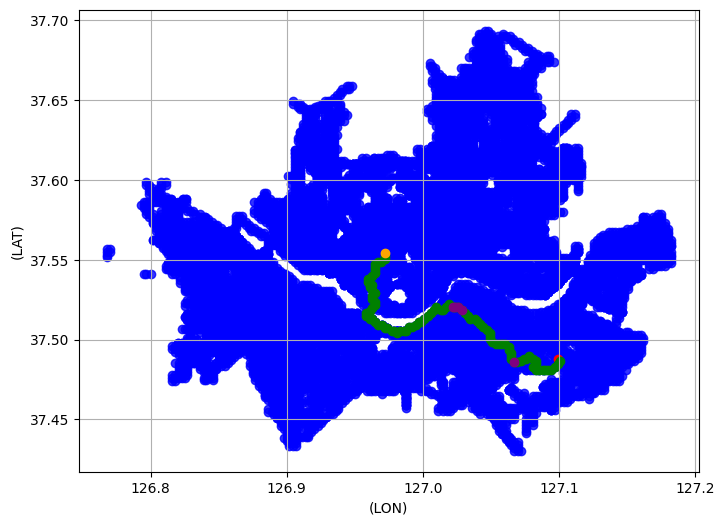

In [20]:
def plot_optimal_path(ax,paths,color,label):
    """주어진 경로를 지도 위에 플롯합니다."""
    for path in paths:
        xs = path[1]
        ys = path[0]
        
        ax.scatter(xs, ys, c=color, label=label)
    
def plot_departure_destination(ax,xs,ys,color,label):
    ax.scatter(xs, ys, c=color, label=label)

    
def plot_danger_zones(ax, zones, color, label):
    """위험 지역들을 지도 위에 플롯합니다."""
    for zone in zones[1:-2]:
        ax.scatter(zone['longitude'], zone['latitude'], c=color, label=label)
        
def visualize_best_route(data,optimal_path,throw_jason):
    # figure,ax 생성
    fig,ax = plt.subplots(figsize=(8,6))
    
    # 서울시 시각화
    ax.scatter(data['LON'], data['LAT'], c='blue', label='위치', alpha=0.8)
    
    # 최적 경로 시각화
    # 경로의 시작과 끝에 대한 색상과 레이블 설정
    
    start_label = "시작 위치"
    end_label = "종료 위치"
    mid_label = "경유 위치"
        
    # 첫번 째 값과 마지막 값은 다른 색으로 표시
    plot_departure_destination(ax, optimal_path[0][1],optimal_path[0][0], 'red', start_label)
    plot_optimal_path(ax, optimal_path[1:-1],'green', mid_label)
    plot_departure_destination(ax, optimal_path[-1][1],optimal_path[-1][0], 'orange', end_label)
    
     # 위험도 지역 시각화
    plot_danger_zones(ax, throw_jason, 'purple', '위험 지역')
    
    # 레이블과 제목 설정
    ax.set_xlabel('(LON)')
    ax.set_ylabel('(LAT)')
    #ax.legend()  # 범례 표시
    ax.grid(True)  # 그리드 표시

data = pd.read_csv('서울시_점수.csv')
    
visualize_best_route(data, optimal_path,throw_jason)